In [105]:
regenerate = True

import numpy as np
import pylab as pb
import GPy
import copy as cp

pb.ion()

file_base = "modularized_v5_backup/"

X = np.load("hc_baby.npy", allow_pickle=True)
Y = np.log(np.load("samples_baby.npy", allow_pickle=True))

In [106]:
X_raw = np.load(file_base + "hc_backup_i1799_massive_pred.npy", allow_pickle=True)
Y_raw = np.load(file_base + "samples_backup_i1799_massive_pred.npy", allow_pickle=True)
X_raw = X_raw[:1800]
Y_raw = Y_raw[:1800]

In [107]:
scales = np.load("standard_k.npy", allow_pickle=True)

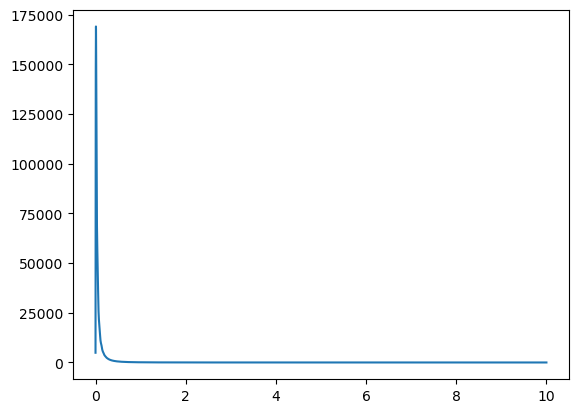

In [108]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.plot(scales, Y_raw[0])

In [109]:
''' To get a sense of how much we're deleting.
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if float('-inf') in pspec:
        print("-inf")
    if float('inf') in pspec:
        print("inf")
    if None in pspec:
        print("None")
    if True in np.isnan(pspec):
        print("NaN in row", i)
        print(X_truncated[i])
    if 0 in pspec:
        print("zero")
'''

' To get a sense of how much we\'re deleting.\nfor i in range(len(Y_truncated)):\n    pspec = Y_truncated[i]\n    if float(\'-inf\') in pspec:\n        print("-inf")\n    if float(\'inf\') in pspec:\n        print("inf")\n    if None in pspec:\n        print("None")\n    if True in np.isnan(pspec):\n        print("NaN in row", i)\n        print(X_truncated[i])\n    if 0 in pspec:\n        print("zero")\n'

In [110]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [111]:
# Now the goal is to compute summary statistics on Y for each value k
Ylog = np.log(Y)
mu = np.mean(Ylog, axis=0)
mu.shape
stdev = np.std(Ylog, axis=0)
stdev.shape

(300,)

In [112]:
# now normalize the data with these summary statistics
Y_normalized = cp.deepcopy(Ylog)

for i in range(len(Y)):
    Y_normalized[i] -= mu
    Y_normalized[i] /= stdev

In [113]:
def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * stdev + mu)

In [114]:
print(X.shape, Y_normalized.shape)

(1796, 6) (1796, 300)


In [115]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y_normalized,kernel)

In [116]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../nuCOMET/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

test_omnuh2 = 0.002

m0_without_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], 0, 0)
m0_with_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], test_omnuh2, 1)

m0_with_neuts['omch2'] -= test_omnuh2

In [117]:
# We'll need to check our work using CAMB
k_m0truth, z_m0truth, p_m0truth, _ = ci.kzps(m0_with_neuts,
    fancy_neutrinos=False, redshifts=[0], k_points=300, hubble_units=False)

_, _, _, s_m0truth = ci.kzps(m0_without_neuts, fancy_neutrinos=False,
    redshifts=[0], k_points=300, hubble_units=False)

m0_without_neuts['sigma12'] = m0_with_neuts['sigma12'] = 0.82466774

print(s_m0truth)

[0.82466774]


In [118]:
spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../nuCOMET/generate_training_data.py")
gtd = importlib.util.module_from_spec(spec)
sys.modules["generate_training_data"] = gtd
spec.loader.exec_module(gtd)

In [119]:
p_m0truth, actual_sigma12, best_z = gtd.psz(m0_with_neuts, scales)

In [120]:
import pickle

if regenerate:
    m.constrain_positive('') # '' is a regex matching all parameter names
    m.optimize()
    
    m.mu = mu
    m.stdev = stdev
    pickle.dump(m, open("analyses/massive_emulator_1800.nucomet", "wb"), protocol=5) 
else:
    m = pickle.load(open("analyses/massive_emulator_1800.nucomet", "rb"))

In [121]:
# Remember that the structure of an hc entry is DIFFERENT NOW
# omb, omc, ns, s12, As, omnu
x = np.array([np.array([
    m0_with_neuts['ombh2'], m0_with_neuts['omch2'], m0_with_neuts['n_s'],
    s_m0truth, m0_with_neuts['A_s'], m0_with_neuts['omnuh2']
])])
x

 /tmp/ipykernel_249587/3024821387.py:3: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array([[0.022445, 0.11856699999999999, 0.96, array([0.82466774]),
        2.1272378801300004e-09, 0.002]], dtype=object)

In [122]:
guess, uncertainties = m.predict(x)

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

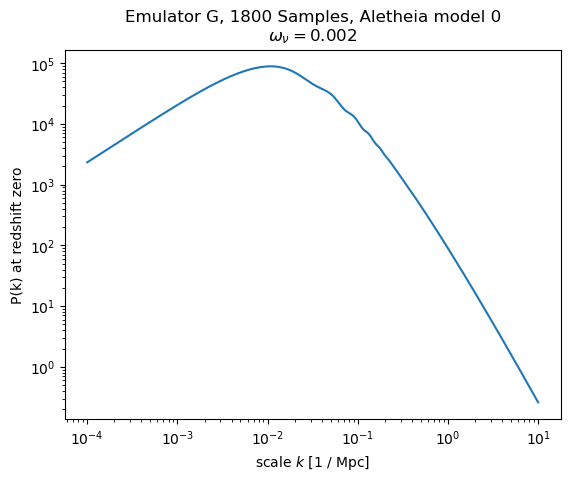

In [123]:
#import matplotlib.pyplot as plt
pb.loglog(scales, inverse_transform(guess[0]))
pb.title("Emulator G, 1800 Samples, Aletheia model 0\n" + r"$\omega_\nu=0.002$")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

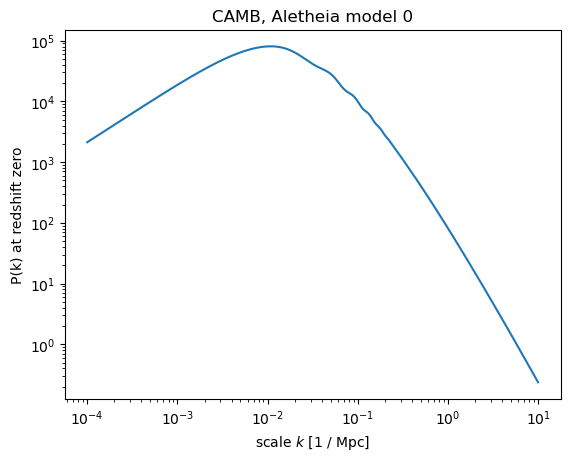

In [124]:
#import matplotlib.pyplot as plt
pb.loglog(k_m0truth, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

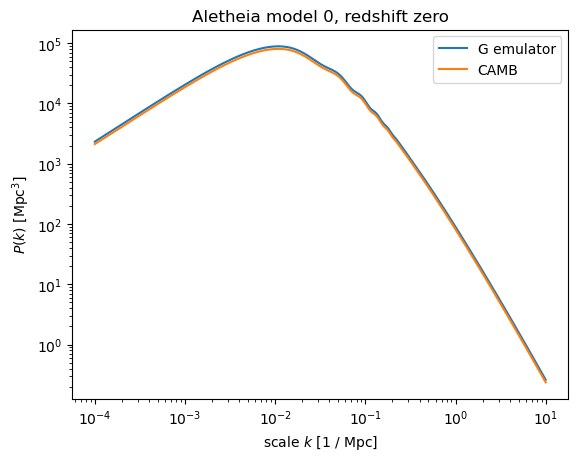

In [125]:
pb.plot(scales, inverse_transform(guess[0]),
    label="G emulator")
pb.loglog(k_m0truth, p_m0truth, label="CAMB")
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

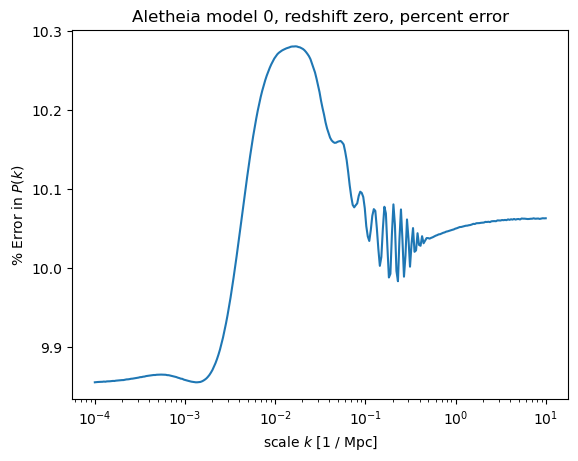

In [126]:
pb.plot(scales,
    (inverse_transform(guess[0]) - p_m0truth) / p_m0truth * 100)
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')

In [127]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.01, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.92, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(x_lo_ns)


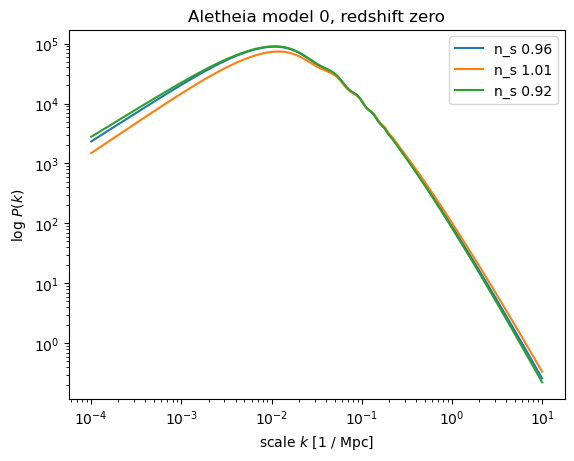

In [128]:
pb.loglog(scales, inverse_transform(guess[0]), label="n_s 0.96")
pb.loglog(scales, inverse_transform(guess_hi_ns[0]), label="n_s 1.01")
pb.loglog(scales, inverse_transform(guess_lo_ns[0]), label="n_s 0.92")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

In [129]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_hi
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(x_hi_omnu)

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_mid,
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(x_mid_omnu)


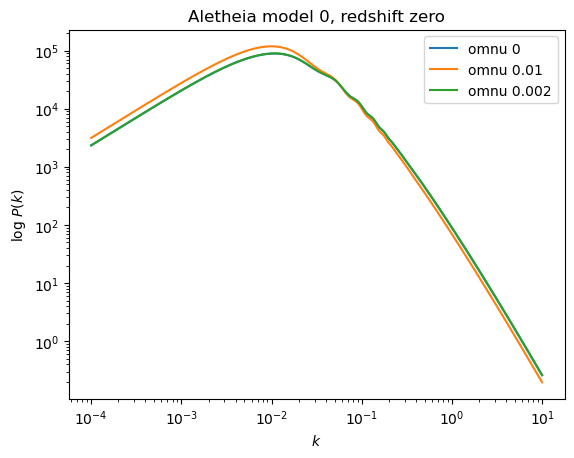

In [130]:
pb.loglog(scales, inverse_transform(guess[0]),
          label="omnu 0")
pb.loglog(scales, inverse_transform(guess_hi_omnu[0]),
          label="omnu 0.01")
pb.loglog(scales, inverse_transform(guess_mid_omnu[0]),
          label="omnu 0.002")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [131]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omb = np.array([np.array([
    0.02415, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omb, uncertainties_hi_omb = m.predict(x_hi_omb)

x_lo_omb = np.array([np.array([
    0.0205, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omb, uncertainties_lo_omb = m.predict(x_lo_omb)


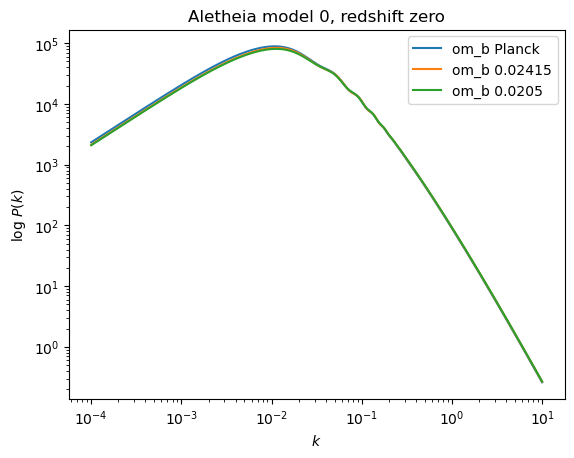

In [132]:
pb.loglog(scales, inverse_transform(guess[0]),
        label="om_b Planck")
pb.loglog(scales, inverse_transform(guess_hi_omb[0]),
        label="om_b 0.02415")
pb.loglog(scales, inverse_transform(guess_lo_omb[0]),
        label="om_b 0.0205")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [133]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omc = np.array([np.array([
    0.022445, 0.155, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omc, uncertainties_hi_omc = m.predict(x_hi_omc)

x_lo_omc = np.array([np.array([
    0.022445, 0.085, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omc, uncertainties_lo_omc = m.predict(x_lo_omc)


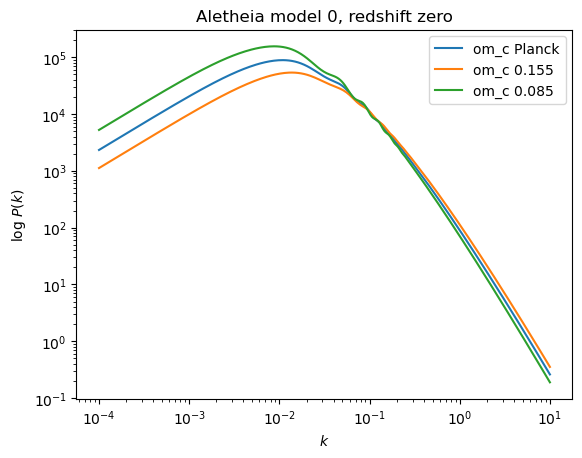

In [134]:
pb.loglog(scales, inverse_transform(guess[0]),
        label="om_c Planck")
pb.loglog(scales, inverse_transform(guess_hi_omc[0]),
        label="om_c 0.155")
pb.loglog(scales, inverse_transform(guess_lo_omc[0]),
        label="om_c 0.085")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [135]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(3.91) / 10 ** 10, 0
])])
guess_hi_As, uncertainties_hi_As = m.predict(x_hi_As)
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(2.35) / 10 ** 10, 0
])])
guess_lo_As, uncertainties_lo_As = m.predict(x_lo_As)

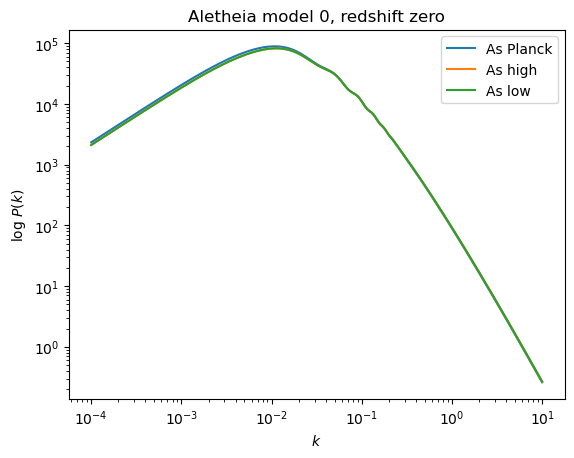

In [136]:
pb.loglog(scales, inverse_transform(guess[0]), label="As Planck")
pb.loglog(scales, inverse_transform(guess_hi_As[0]), label="As high")
pb.loglog(scales, inverse_transform(guess_lo_As[0]), label="As low")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

I guess this shows that sigma12 countermands As, huh?